In [1]:
import pandas as pd
from pathlib import Path

In [2]:
train_dir = Path('../assets/clahe_images_full')
data_filepaths = list(train_dir.glob(r'**/*.jpg'))
print( len(data_filepaths))

2874


In [3]:
def proc_img(filepath):
    """
    Spracovanie ciest k obrazovým súborom na extrakciu labelov a vytvorenie DataFrame.

    Args:
    - (zoznam): Zoznam ciest k súborom.

    Returns: Súbor súborov (zoznam súborov):
    - df (DataFrame): Pandas DataFrame obsahujúci cesty k súborom a labele.
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [4]:
df = proc_img(data_filepaths)

In [5]:
df.head()

Filepath     Label
0  clahe_images_full\normal\OIA-ODIR-TEST-ONLINE-...    normal
1  clahe_images_full\glaucoma\EyePACS-Glaucoma-10...  glaucoma
2  clahe_images_full\glaucoma\EyePACS-Glaucoma-31...  glaucoma
3       clahe_images_full\glaucoma\ORIGA-386_roi.jpg  glaucoma
4  clahe_images_full\glaucoma\EyePACS-Glaucoma-23...  glaucoma

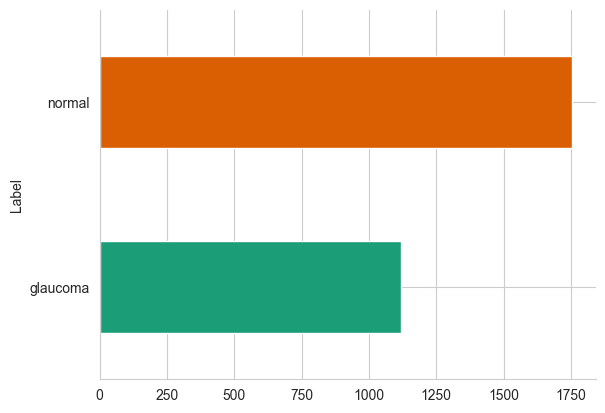

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
print("Found Label classes: ", df["Label"].unique())

The dataframe have 2 columns and 2874 rows
We have 2 differents categories of retinal images
['normal' 'glaucoma']


In [8]:
s=df.copy()
percent_dict={}
N=s.shape[0]
for i in s["Label"].unique():
    d=s.loc[s["Label"]==i]
    n=d.shape[0]
    p=n/N*100
    percent_dict[i]=p

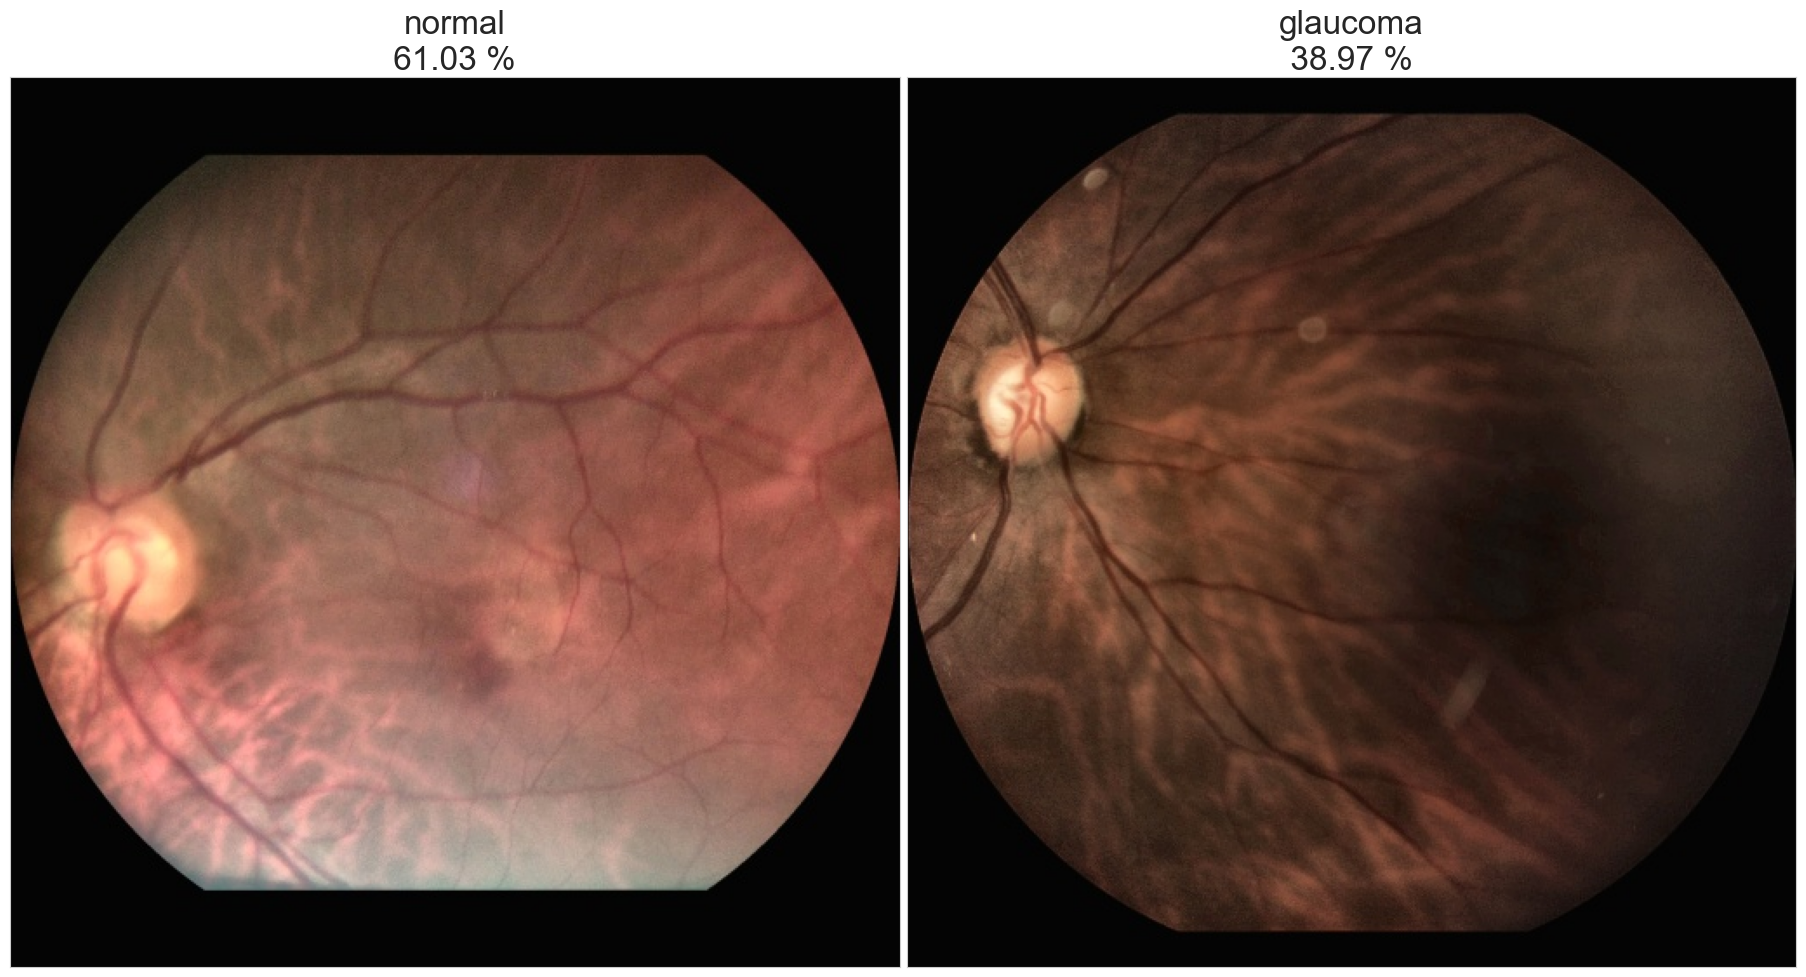

In [9]:
# Percentuálny pomer zastúpenia zdravých a glaukomových ochorení v zloženom súbore údajov

df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i]+"\n {} % ".format(round(percent_dict[df_unique.Label[i]],2))
                 , fontsize = 24)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
import pandas as pd

total_samples = 4000
num_normal_samples = total_samples // 2
num_glaucoma_samples = total_samples - num_normal_samples

normal_data = df[df["Label"] == "normal"]
glaucoma_data = df[df["Label"] == "glaucoma"]

oversampled_glaucoma_data = glaucoma_data.sample(n=num_glaucoma_samples, replace=True)

oversampled_normal_data = normal_data.sample(n=num_normal_samples, replace=True)

balanced_df = pd.concat([oversampled_glaucoma_data, oversampled_normal_data])

sample = balanced_df.sample(frac=1).reset_index(drop=True)

In [11]:
num_normal_samples = (sample["Label"] == "normal").sum()
num_glaucoma_samples = (sample["Label"] == "glaucoma").sum()

print("Number of samples for 'normal_onh' class:", num_normal_samples)
print("Number of samples for 'glaucoma_onh' class:", num_glaucoma_samples)

Number of samples for 'normal_onh' class: 2000
Number of samples for 'glaucoma_onh' class: 2000


In [12]:
s=sample.copy()
percent_dict={}
N=s.shape[0]
for i in s["Label"].unique():
    d=s.loc[s["Label"]==i]
    n=d.shape[0]
    p=n/N*100
    percent_dict[i]=p

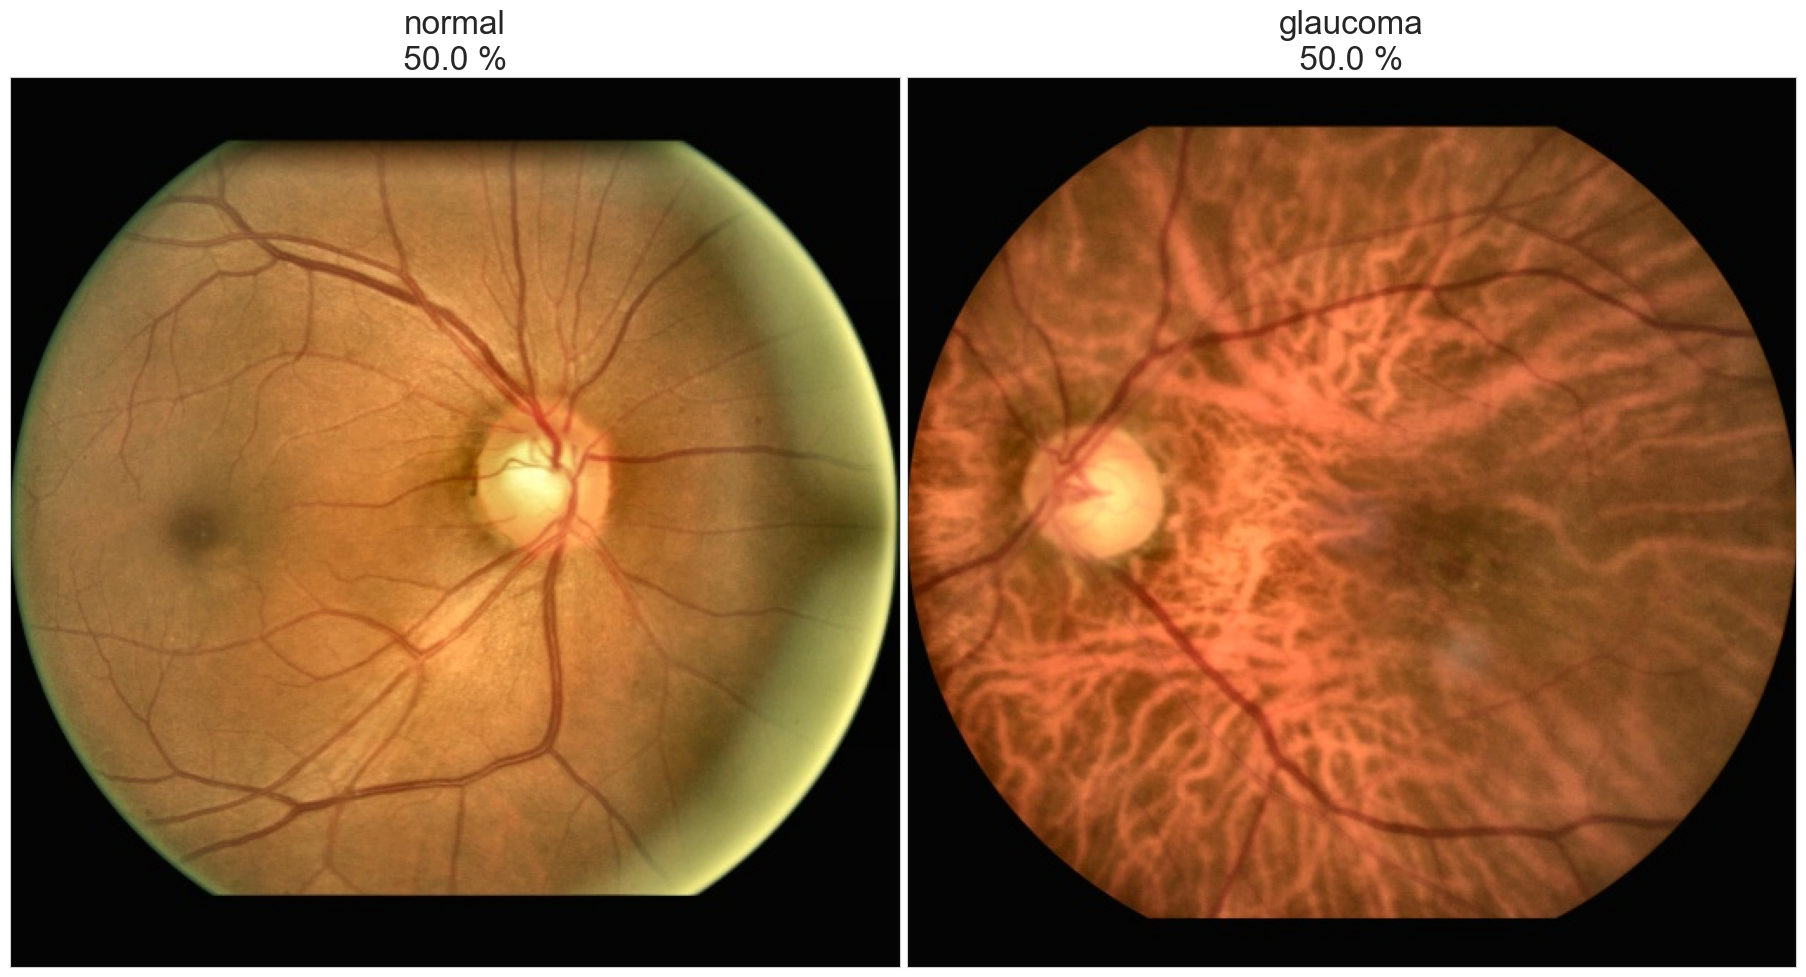

In [13]:
# Percentuálny pomer zastúpenia zdravých a glaukomových ochorení v zloženom súbore údajov po nadvzorkovani a podvzorkovaní

df_unique = sample.copy().drop_duplicates(subset=["Label"]).reset_index()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i]+"\n {} % ".format(round(percent_dict[df_unique.Label[i]],2))
                 , fontsize = 24)
plt.tight_layout(pad=0.5)
plt.show()

In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import pandas as pd
from PIL import Image, ImageOps
import cv2
import numpy as np

In [15]:
def preprocess_images(path):
    """
    Funkcia aplikujúca rôzne kroky predbežného spracovania obrazu.

    Args:
    - (str): Cesta k vstupnému obrazu.

    Returns:
    - img (pole): Predspracované pole obrazov.
    """

    preprocessed_fundus_image = cv2.imread(path)
    preprocessed_fundus_image = cv2.resize(preprocessed_fundus_image, (224, 224), interpolation=cv2.INTER_CUBIC)

    preprocessed_fundus_image = cv2.fastNlMeansDenoisingColored(preprocessed_fundus_image, None, 10, 10, 7, 21)
    preprocessed_fundus_image = ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(preprocessed_fundus_image),cutoff=5))
    preprocessed_fundus_image = img_to_array(preprocessed_fundus_image)
    preprocessed_fundus_image = cv2.GaussianBlur(preprocessed_fundus_image, (5, 5) ,0)
    preprocessed_fundus_image = preprocess_input(preprocessed_fundus_image)
    return preprocessed_fundus_image

In [ ]:
model = ResNet50(weights='imagenet',include_top=False,pooling="avg")

In [16]:
def extract_features(img):
    """
    Funkcia aplikujúca extrakciu príznakov pomocou predtrénovaného modelu ResNet50.

    Args:
    - img (PIL.Image): Vstupný obraz.

    Returns: Image (obraz):
    - výstup (zoznam): Extrahované príznaky.
    """

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    features = model.predict(x)
    output = [p.flatten() for p in features]
    return list(output[0])

In [17]:
original_image = cv2.imread(sample["Filepath"].values[0])
image_bgr = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_bgr, (224, 224),interpolation=cv2.INTER_CUBIC)
image_denoise = cv2.fastNlMeansDenoisingColored(image_resized, None, 10, 10, 7, 21)
image_contrast = np.array(ImageOps.equalize(ImageOps.autocontrast(Image.fromarray(image_denoise), cutoff=5)))
image_gaussian = cv2.GaussianBlur(image_contrast, (5, 5), 0)
image_arr = img_to_array(image_gaussian)
image_preprocess = preprocess_input(image_arr)

(-0.5, 223.5, 223.5, -0.5)

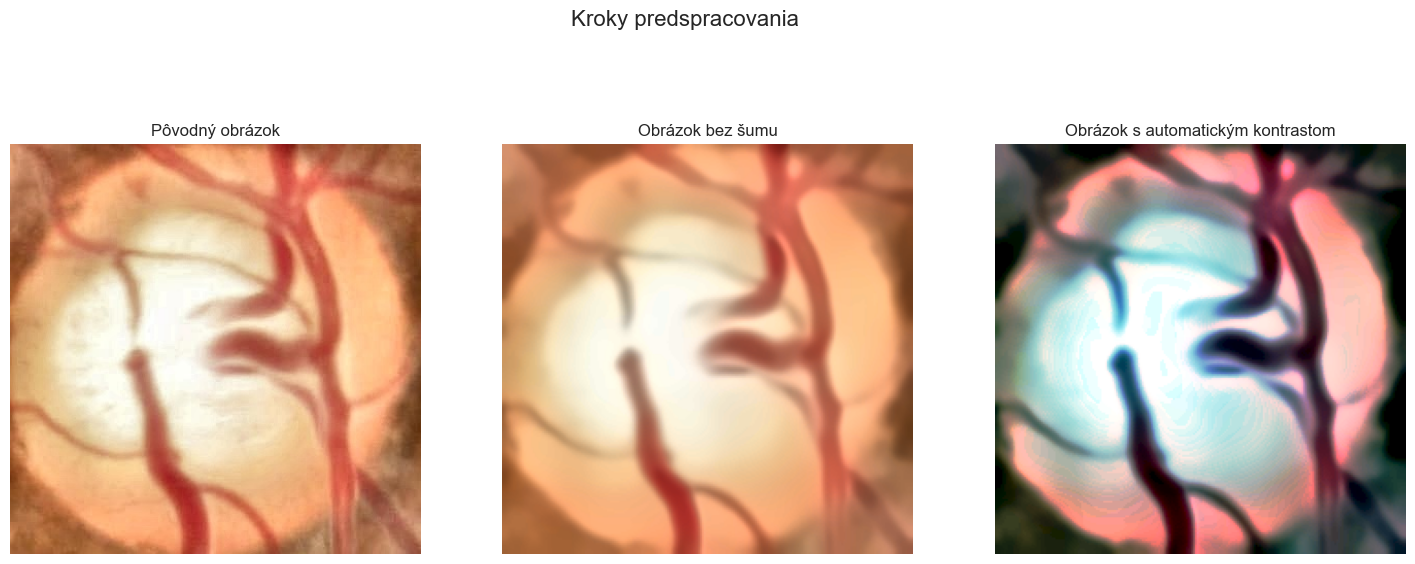

In [20]:
# Vizualizácia krokov predspracovania

fig=plt.figure(figsize=[18,7])
plt.suptitle("Kroky predspracovania",size=16)
plt.subplot(1,3,1)
plt.title("Pôvodný obrázok")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Obrázok bez šumu")
plt.imshow(image_denoise)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Obrázok s automatickým kontrastom")
plt.imshow(image_contrast)
plt.axis('off')

In [18]:
from tqdm import tqdm

preprocessed_images = []

for filepath in tqdm(sample["Filepath"], total=len(sample)):
    preprocessed_images.append(preprocess_images(filepath))

sample["Preprocessed images"] = preprocessed_images

In [19]:
sample["Features"] = sample["Preprocessed images"].apply(extract_features)

1/1 [==============================] - 0s 19ms/step


In [20]:
print(sample.shape)

(4000, 4)


Extracted features from ResNet50:
0       [1.4410278, 0.4140275, 0.017597374, 0.09527933...
1       [2.5422916, 0.58855724, 0.0047905655, 0.034334...
2       [2.0320795, 0.09843872, 1.4751236, 0.14446312,...
3       [2.8528318, 0.20371932, 0.39331394, 0.10443880...
4       [5.8823323, 0.028459715, 0.011946117, 0.0, 1.2...
                              ...                        
3995    [1.8582538, 0.14004509, 0.08239629, 0.01132625...
3996    [2.7466373, 0.019601168, 0.081456184, 0.0, 1.9...
3997    [2.1808, 0.08563223, 0.14047691, 0.0, 0.498492...
3998    [2.4283957, 0.1494283, 0.016348097, 0.0, 0.006...
3999    [3.5636756, 0.21770759, 0.36323938, 0.0, 1.743...
Name: Features, Length: 4000, dtype: object


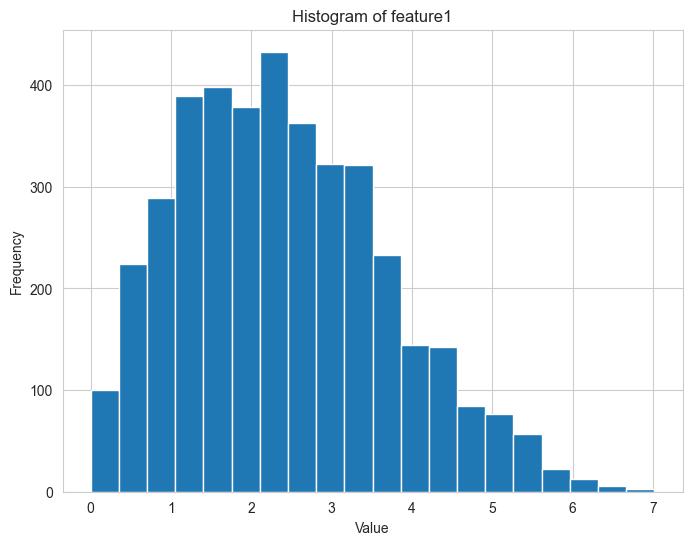

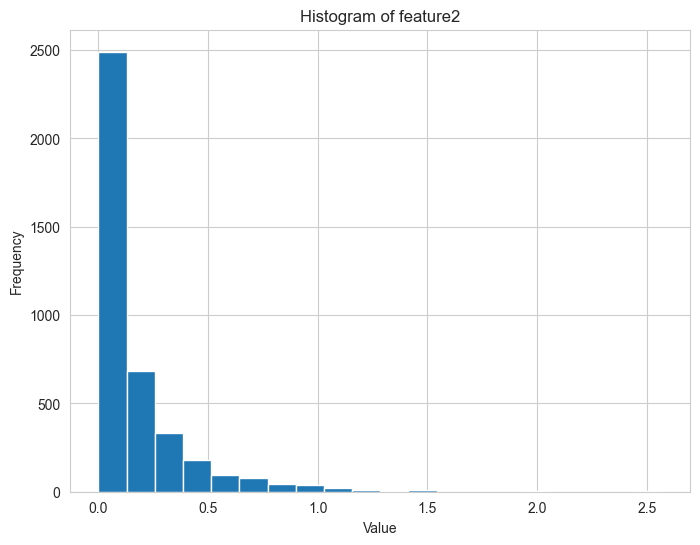

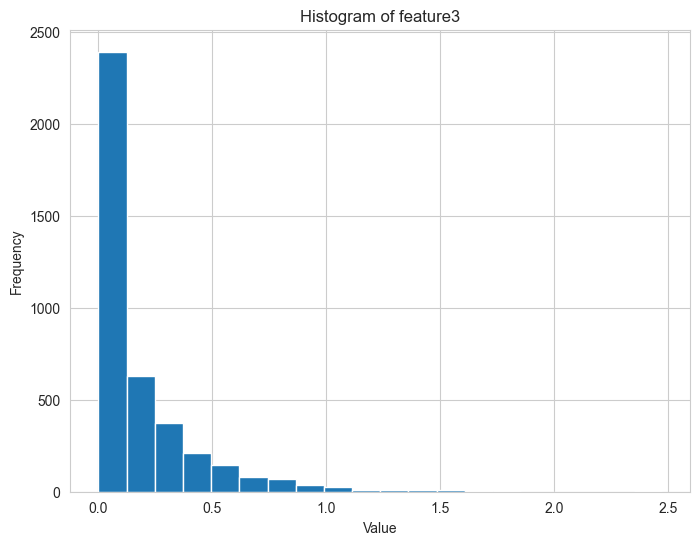

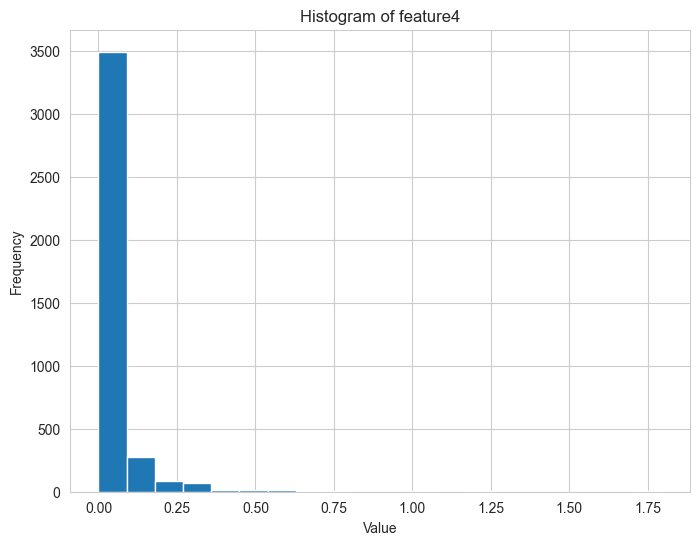

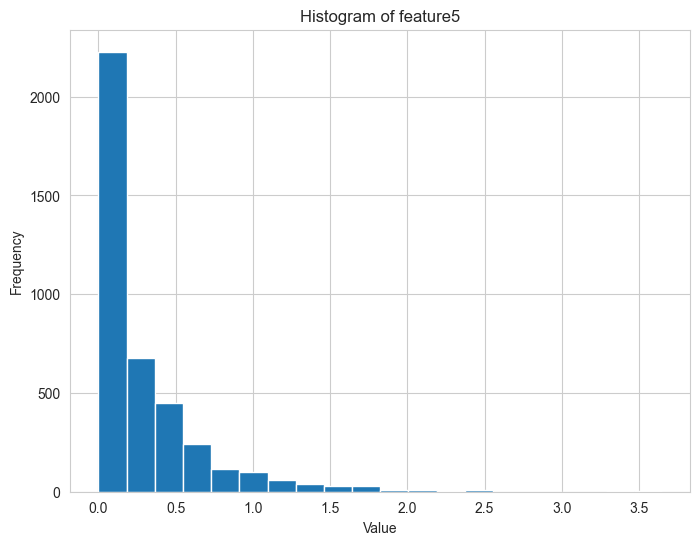

In [25]:
print("Extracted features from ResNet50:")
print(sample["Features"])

# Vizualizacia extrahovaých príznakov

num_features_to_visualize = 5
for i in range(num_features_to_visualize):
    feature_name = "feature{}".format(i+1)
    plt.figure(figsize=(8, 6))
    plt.hist(sample["Features"].apply(lambda x: x[i]), bins=20) 
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Histogram of {}".format(feature_name))
    plt.show()

In [26]:
sample.to_csv("output_after_preprocessing.csv", index=False)

In [27]:
#sample = pd.read_csv("output_after_preprocessing.csv")

In [21]:
for i in range(0,len(sample["Features"].values[0])):
    def format_features(val):
        x=val[i]
        return x
    sample["feature{}".format(i+1)] = sample["Features"].apply(format_features)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2392\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample["feature{}".format(i+1)]=sample["Features"].apply(format_features)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2392\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sample["feature{}".format(i+1)]=sample["Features"].apply(format_features)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2392\3533284626.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

In [22]:
sample.head()

Filepath     Label  \
0         clahe_images_full\normal\ORIGA-298_roi.jpg    normal   
1  clahe_images_full\glaucoma\OIA-ODIR-TEST-OFFLI...  glaucoma   
2  clahe_images_full\glaucoma\EyePACS-Glaucoma-11...  glaucoma   
3  clahe_images_full\normal\OIA-ODIR-TEST-ONLINE-...    normal   
4  clahe_images_full\glaucoma\EyePACS-Glaucoma-14...  glaucoma   

                                 Preprocessed images  \
0  [[[-103.939, -116.779, -123.68], [-103.939, -1...   
1  [[[-103.939, -116.779, -123.68], [-103.939, -1...   
2  [[[-103.939, -116.779, -123.68], [-103.939, -1...   
3  [[[-103.939, -116.779, -123.68], [-103.939, -1...   
4  [[[-103.939, -116.779, -123.68], [-103.939, -1...   

                                            Features  feature1  feature2  \
0  [1.5708278, 0.1281196, 0.0, 0.18514003, 1.6861...  1.570828  0.128120   
1  [0.87039393, 0.1653578, 0.07018115, 0.10381728...  0.870394  0.165358   
2  [1.5580988, 0.98335546, 0.021249793, 0.1503059...  1.558099  0.983355   
3  [1.5612845, 0.27464372, 0.007887102, 0.0833600...  1.561285  0.274644   
4  [2.0436246, 0.27468872, 0.012754785, 0.5028827...  2.043625  0.274689   

   feature3  feature4  feature5  feature6  ...  feature2039  feature2040  \
0  0.000000  0.185140  1.686159  0.000000  ...     0.108002     0.488518   
1  0.070181  0.103817  0.111902  0.022207  ...     0.000000     0.501164   
2  0.021250  0.150306  0.306547  0.640080  ...     0.042777     0.608174   
3  0.007887  0.083360  0.295190  0.000000  ...     0.091884     0.627192   
4  0.012755  0.502883  0.129632  0.000000  ...     0.000000     0.200288   

   feature2041  feature2042  feature2043  feature2044  feature2045  \
0     0.814990     0.009498     0.132043     0.094573     0.203103   
1     0.597327     0.030080     0.431717     0.878447     0.132955   
2     0.329969     0.218101     0.300327     0.664242     0.168477   
3     0.183968     0.000000     0.173754     0.089201     0.018077   
4     0.477646     0.562871     0.080100     0.670005     0.317136   

   feature2046  feature2047  feature2048  
0     0.000000     0.815616     1.158558  
1     0.000000     0.092129     0.650598  
2     0.000000     0.149938     0.547480  
3     0.000000     0.018595     0.110899  
4     0.002088     0.589760     1.857101  

[5 rows x 2052 columns]

Text(0, 0.5, 'explained_variance_ratio_')

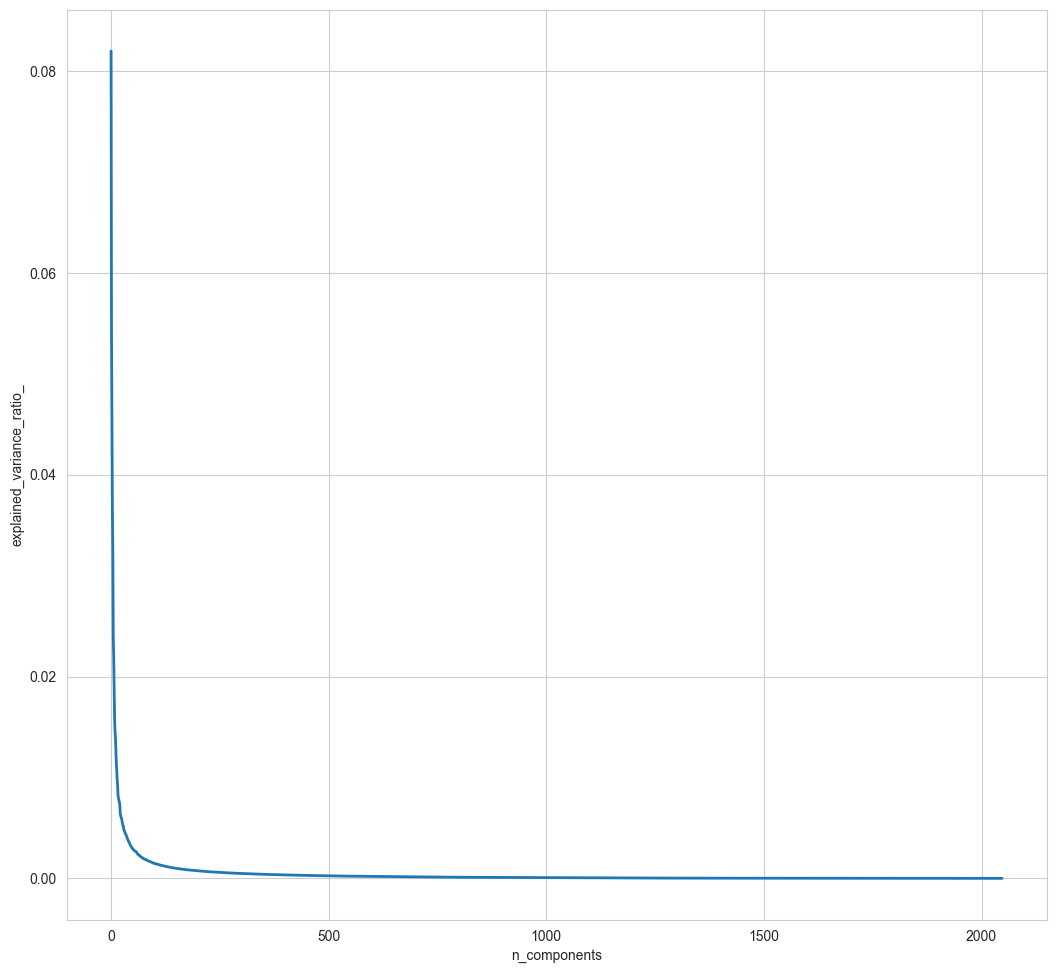

In [23]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Redukcia dimenzionality použitím PCA

features = sample.drop(columns=['Filepath', 'Label', 'Preprocessed images', 'Features'])
scaler = StandardScaler()
ss = scaler.fit_transform(features)

pca = decomposition.PCA(n_components=min(features.shape[1],
                                             features.shape[0])).fit(ss)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [24]:
n_components = 0
ratio = pca.explained_variance_ratio_
for i in range(features.shape[1]):
    a = ratio.cumsum()[i]
    if a >= 0.8:
        print("{} principal components explains 80% of variance ratio.".format(i))
        n_components=i
        break

221 principal components explaines  80% of the total variance
Sum of variance explained :80.02%


In [25]:
pca = decomposition.PCA(n_components=n_components)
d=pca.fit_transform(ss)
d=pd.DataFrame(d, columns=["PCA n°{}".format(i+1) for i in range(0,n_components) ])
d["Label"]=sample["Label"].values

In [28]:
d.head()

PCA n°1    PCA n°2    PCA n°3    PCA n°4    PCA n°5   PCA n°6    PCA n°7  \
0  11.457962  -2.106584  18.690268  -2.468340   0.826262 -9.279300   6.951720   
1   2.878499 -14.483438  -6.762431  -4.985972  -8.733382  0.913064  11.540851   
2  -0.091809   4.632877  -7.748773   3.295880  -3.408859  2.250822  -1.543643   
3   4.510557  12.427919 -12.778728 -11.987966  10.532276 -1.630352   6.312956   
4 -13.823437   4.035402   2.074698  -2.912745   4.428558  2.669977  -1.947689   

    PCA n°8    PCA n°9  PCA n°10  ...  PCA n°239  PCA n°240  PCA n°241  \
0 -4.348763  -2.911288 -8.072191  ...   0.154368   0.984361  -1.414240   
1 -4.298789  -2.379110 -2.902520  ...   0.856817  -0.811180   0.062447   
2 -3.991558  14.568322 -0.632221  ...  -0.256088  -0.480484   0.329904   
3  8.125057  10.463287 -0.459084  ...  -0.616594   1.524470   1.393778   
4 -1.344616   5.256802  2.203123  ...  -0.297170  -0.241858  -0.400217   

   PCA n°242  PCA n°243  PCA n°244  PCA n°245  PCA n°246  PCA n°247     Label  
0   0.183033   0.422825   0.045286  -0.585912  -0.068503  -0.049076    normal  
1   0.297524  -0.885768  -1.013510   0.815897   1.392228   1.193127    normal  
2   1.654885  -0.156533  -0.029249   1.702328   1.115223   0.252078  glaucoma  
3  -0.544578  -0.804949   0.170916  -3.619254   0.710293   0.239037    normal  
4  -0.311951   0.049967  -0.040393   1.299652  -0.096423   0.374952    normal  

[5 rows x 248 columns]

In [36]:
d.to_csv("output_images_full.csv", index=False)

In [37]:
# Assuming your CSV file is named "output.csv"
#df = pd.read_csv("output.csv")

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y=d["Label"]
X=d.drop(columns=["Label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.svm import SVC

svm = SVC(probability=True)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 300],  # Regularizačný parameter
    'gamma': ['scale'],  # gamma: 'scale', 'auto'
    'kernel': ['rbf']   # Funkcia jadra: 'rbf', 'poly', and 'sigmoid'
}

# 3-krížová validácia s prehľadavaním mriežky (najlepšie hyperparametre)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search.fit(scaled_train,y_train) 
svm_best = grid_search.best_estimator_
pred = svm_best.predict(scaled_test)
score= accuracy_score(y_test,pred)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.5s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   2.2s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   2.1s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.8s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   1.7s
[CV] END ......................C=10, gamma=scale,

In [30]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [136]:
svm = SVC(C=100, kernel='rbf', gamma='scale')

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_svm = svm.fit(scaled_train,y_train) 

pred_one = model_svm.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [31]:
print("Accuracy score:", round(score,4)," on the testing set with SVM.")

Accuracy score: 0.9325  on the testing set with SVM.


In [32]:
from sklearn.metrics import classification_report

print("SVM Classifier Report:")
print(classification_report(y_test, pred, digits=4))

SVM Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9265    0.9444    0.9354       414
      normal     0.9392    0.9197    0.9293       386

    accuracy                         0.9325       800
   macro avg     0.9328    0.9321    0.9324       800
weighted avg     0.9326    0.9325    0.9325       800


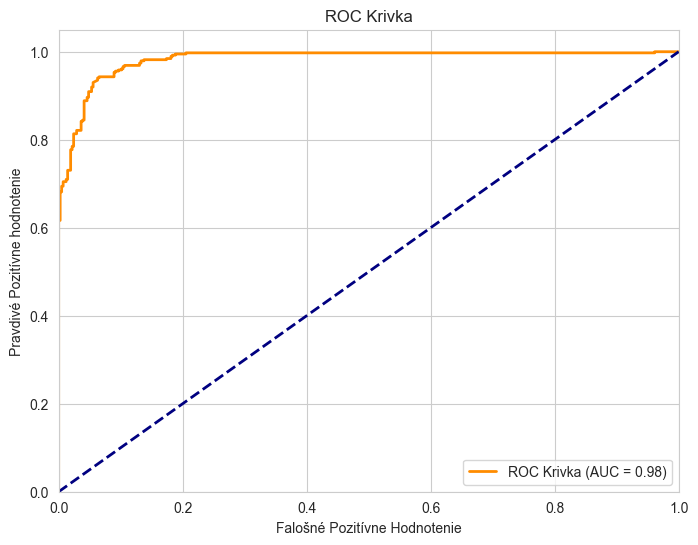

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Výpočet a vizualizácia ROC-AUC krivky

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = svm_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_svm, tpr_svm, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

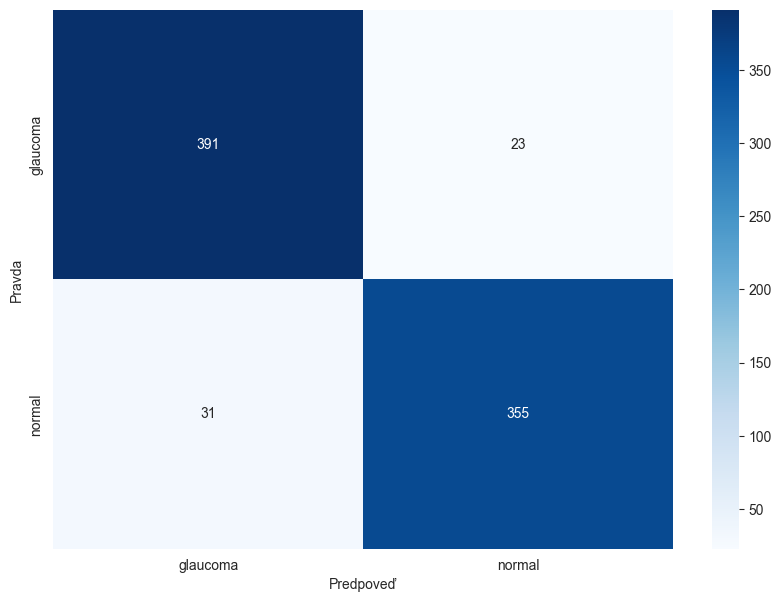

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Vizualizácia konfúznej matice

cm = confusion_matrix(y_test,pred)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_best.classes_, yticklabels=svm_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

RANDOM FORREST

In [35]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 300],   # Počet stromov
    'max_depth': [10, 20],      # Hĺbka stromu
    'max_features': ['sqrt', 'log2']  # Počet funkcií, ktoré treba zohľadniť pri každom rozdelení
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_rf.fit(scaled_train,y_train)
rf_best = grid_search_rf.best_estimator_
pred_rf = rf_best.predict(scaled_test)
score2 = accuracy_score(y_test,pred_rf)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   2.1s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   1.7s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   1.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   3.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   3.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   3.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  10.9s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  10.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=  11.5s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.9s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.8s
[CV] END ...max_depth=10, max_features=log2, n_e

In [36]:
best_params = grid_search_rf.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 300}


In [218]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, max_features=None)

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_rf = rf.fit(scaled_train,y_train) 

pred_one = model_rf.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [37]:
print("Accuracy score:", round(score2,4)," on the testing set with random forest.")

Accuracy score: 0.9112  on the testing set with random forest.


In [38]:
print("Random Forest Classifier Report:")
print(classification_report(y_test, pred_rf, digits=4))

Random Forest Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9409    0.8841    0.9116       414
      normal     0.8832    0.9404    0.9109       386

    accuracy                         0.9113       800
   macro avg     0.9120    0.9122    0.9112       800
weighted avg     0.9131    0.9113    0.9113       800


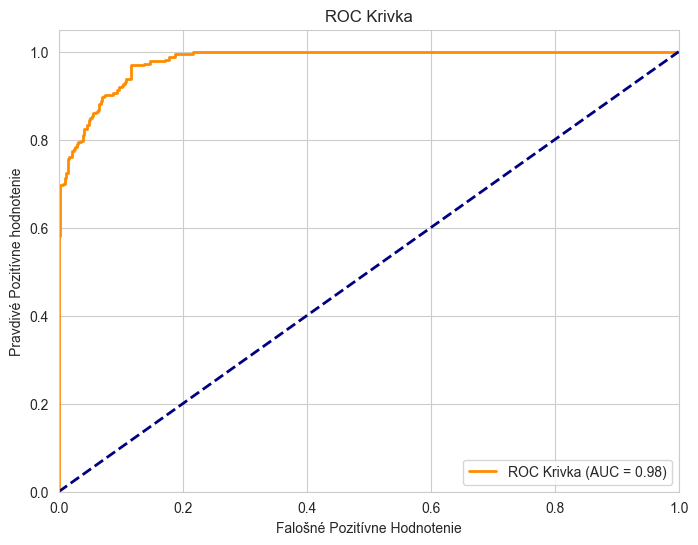

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = rf_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

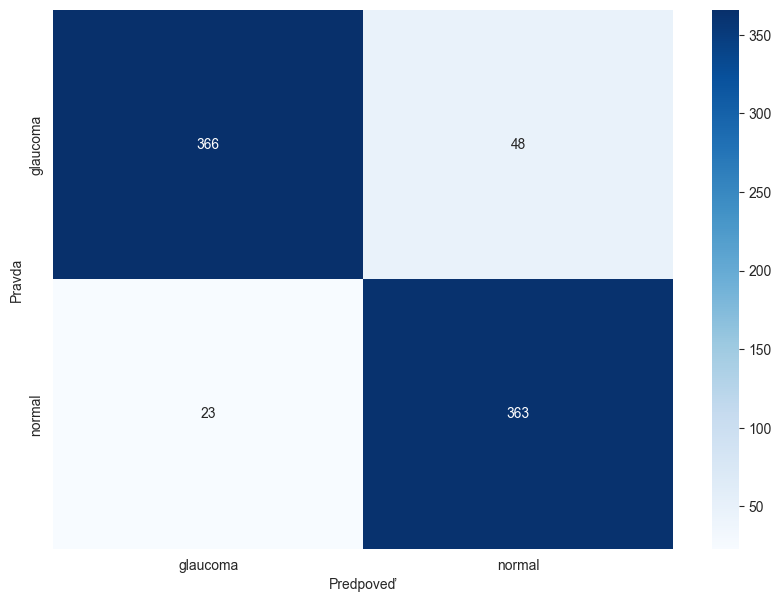

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_rf)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_best.classes_, yticklabels=rf_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

Logistic Regression

In [41]:
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l2'],   # Penalizácia
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularizačná sila
}

lr = LogisticRegression()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_lr.fit(scaled_train, y_train)
lr_best = grid_search_lr.best_estimator_
pred_lr = lr_best.predict(scaled_test)
score3 = accuracy_score(y_test,pred_lr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1,

In [42]:
best_params = grid_search_lr.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.1, 'penalty': 'l2'}


In [165]:
lr = LogisticRegression(C=10, penalty='l2')
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_lr = lr.fit(scaled_train,y_train) 

pred_one = model_lr.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [43]:
print("Accuracy score:", round(score3,4)," on the testing set with logistic regression.")

Accuracy score: 0.7887  on the testing set with logistic regression.


In [44]:
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, pred_lr, digits=4))

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.8165    0.7633    0.7890       414
      normal     0.7627    0.8161    0.7885       386

    accuracy                         0.7887       800
   macro avg     0.7896    0.7897    0.7887       800
weighted avg     0.7906    0.7887    0.7888       800


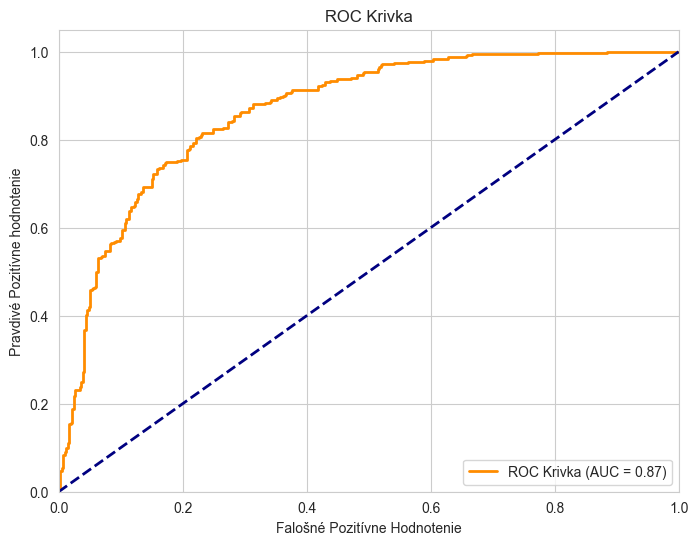

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = lr_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_lr, tpr_lr, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

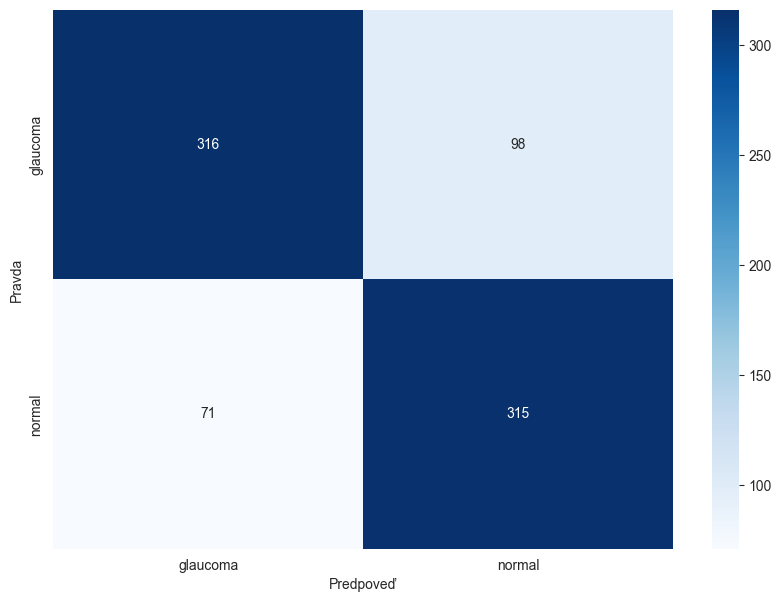

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_lr)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_best.classes_, yticklabels=lr_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

KNN

In [50]:
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 31),   # Počet susedov
    'weights': ['uniform', 'distance'],   # Váhova funkcia na predikciu
}

knn = KNeighborsClassifier()
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_knn.fit(scaled_train, y_train)
knn_best = grid_search_knn.best_estimator_
pred_knn = knn_best.predict(scaled_test)
score5 = accuracy_score(y_test,pred_knn)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, wei

In [51]:
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_neighbors': 10, 'weights': 'distance'}


In [52]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_knn = knn.fit(scaled_train,y_train) 

pred_one = model_knn.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [53]:
print("Accuracy score:", round(score5,4)," on the testing set with KNeighbors.")

Accuracy score: 0.91  on the testing set with KNeighbors.


In [55]:
print("KNN Classifier Report:")
print(classification_report(y_test, pred_knn, digits=4))

AdaBoost Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9476    0.8744    0.9095       414
      normal     0.8756    0.9482    0.9104       386

    accuracy                         0.9100       800
   macro avg     0.9116    0.9113    0.9100       800
weighted avg     0.9129    0.9100    0.9100       800


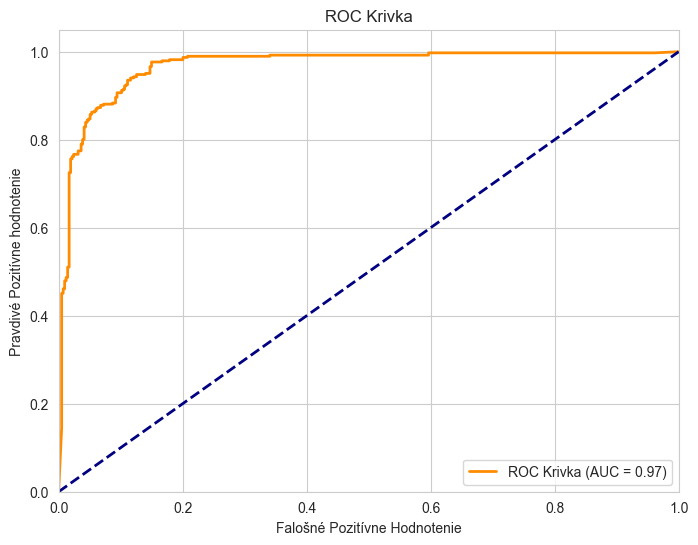

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = knn_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_knn, tpr_knn, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

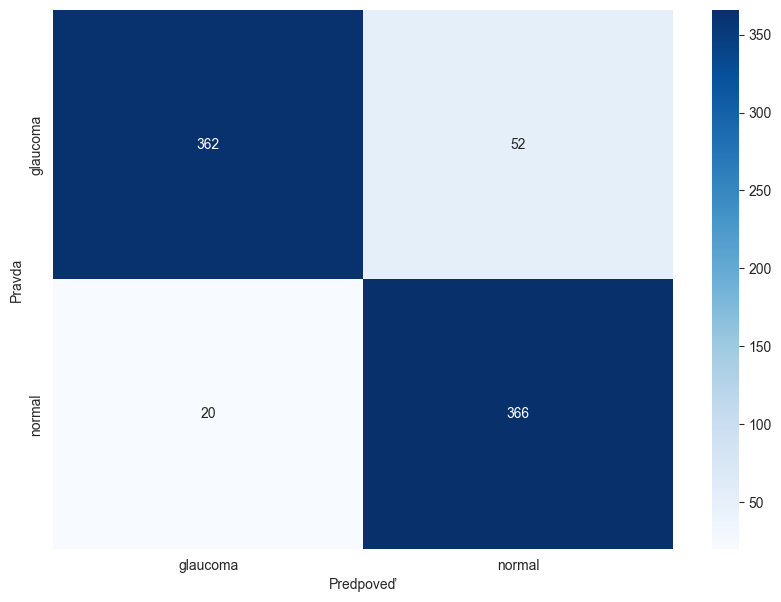

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_knn)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_best.classes_, yticklabels=knn_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

In [58]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import AdaBoostClassifier

base_estimators = [rf_best, svm_best, lr_best]

param_grid = {
    'estimator': base_estimators,   # Základný slabý klasifikátor
    'n_estimators': [50, 100]       # Počet klasifikátorov
}

ab = AdaBoostClassifier()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_ab = GridSearchCV(estimator=ab, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_ab.fit(scaled_train, y_train)
ab_best = grid_search_ab.best_estimator_
pred_ab = ab_best.predict(scaled_test)
score4 = accuracy_score(y_test,pred_ab)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   7.8s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   7.7s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   7.6s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   7.5s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   8.5s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   7.9s
[CV] END estimator=SVC(C=100, probability=True), n_estimators=50; total time= 2.5min
[CV] END estimator=SVC(C=100, probability=True), n_estimator

C:\Users\Admin\Documents\xknapcok\Project\dp-glaucoma-detection\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\Documents\xknapcok\Project\dp-glaucoma-detection\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\Documents\xknapcok\Project\dp-glaucoma-detection\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Admin\Documents\xknapc

In [59]:
best_params = grid_search_ab.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'estimator': RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), 'n_estimators': 50}


In [214]:
ab = AdaBoostClassifier(estimator=lr_best, n_estimators=10)
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
model_ab = ab.fit(scaled_train,y_train) 

pred_one = model_ab.predict(scaled_test)
score_one = accuracy_score(y_test,pred_one)

In [60]:
print("Accuracy score:", round(score4,4)," on the testing set with AdaBoost.")

Accuracy score: 0.9138  on the testing set with AdaBoost.


In [61]:
print("AdaBoost Classifier Report:")
print(classification_report(y_test, pred_ab, digits=4))

AdaBoost Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.9576    0.8720    0.9128       414
      normal     0.8747    0.9585    0.9147       386

    accuracy                         0.9137       800
   macro avg     0.9161    0.9153    0.9137       800
weighted avg     0.9176    0.9137    0.9137       800


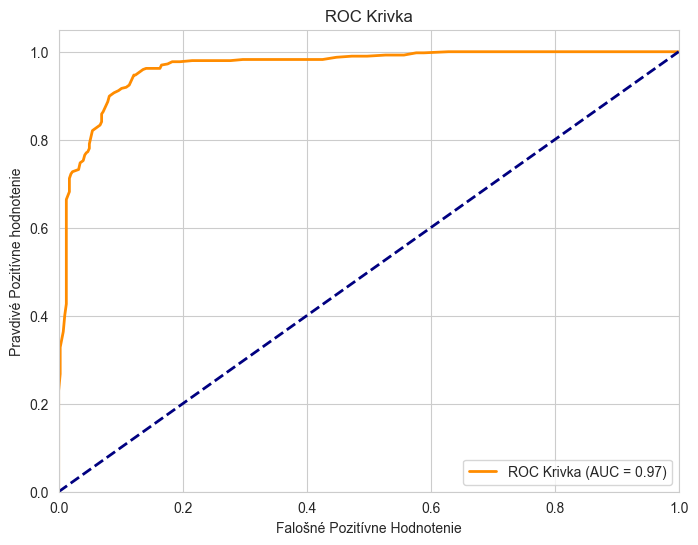

In [74]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = ab_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_ab, tpr_ab, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_ab = auc(fpr_ab, tpr_ab)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_ab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

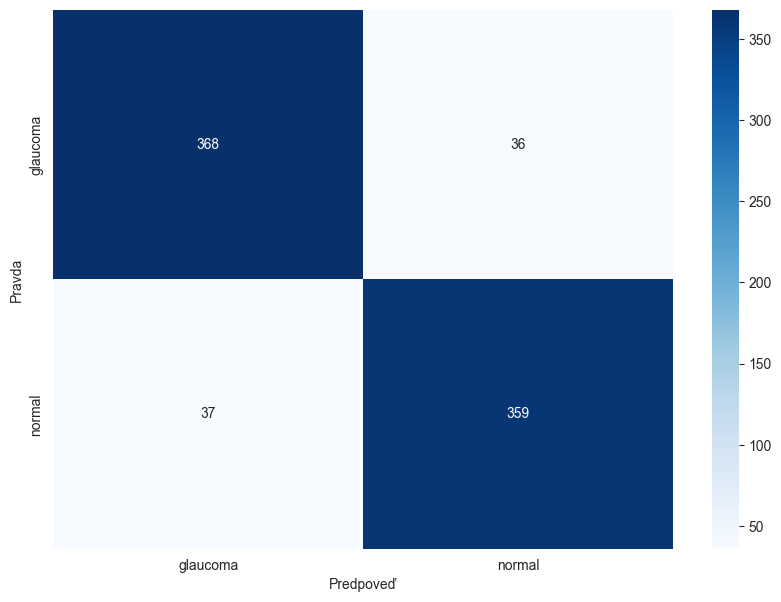

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_ab)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ab_best.classes_, yticklabels=ab_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

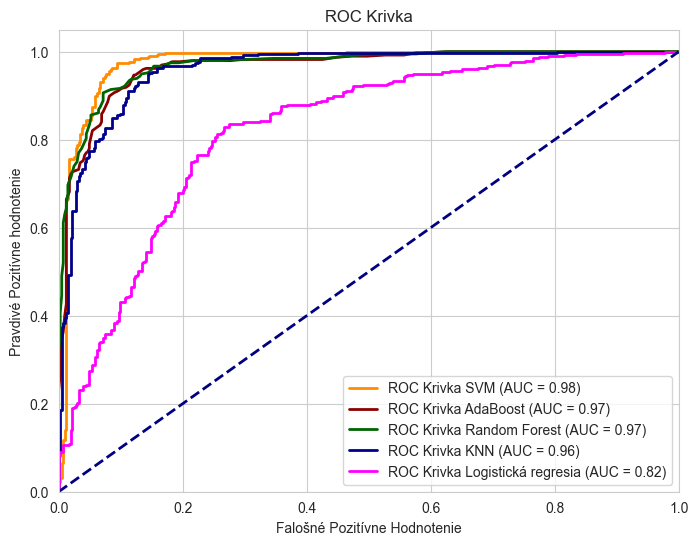

In [77]:
# ROC-AUC krivka pre všetký klasifikátory
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_ab, tpr_ab, color='darkred', lw=2, label='ROC Krivka AdaBoost (AUC = %0.2f)' % roc_auc_ab)
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='ROC Krivka Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_knn, tpr_knn, color='darkblue', lw=2, label='ROC Krivka KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_lr, tpr_lr, color='magenta', lw=2, label='ROC Krivka Logistická regresia (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()